In [1]:
import struct
import pandas as pd
import plotly
import plotly.graph_objs as go

In [2]:
STATE_MAP = {
    0: 'INVALID',
    1: 'MOVING',
    2: 'IDLE',
    3: 'THRUSTING_1',
    4: 'THRUSTING_2',
    5: 'COASTING',
    6: 'TRANSONIC_1',
    7: 'SUPERSONIC',
    8: 'TRANSONIC_2',
    9: 'APOGEE',
    10: 'PARACHUTE',
    11: 'BALLISTIC',
    12: 'TOUCHDOWN',
    0x7FFFFFFF: 'HEHE'
}

layout_font = dict(
            family="Courier New, monospace",
            size=12
        )

legend = dict(orientation="h", y = 1.13)

In [3]:
log = 'flight_logs/flight_day_2/flight_008_sensor_offset.txt'

In [4]:
log_b = None
with open(log, 'r') as f:
    log_str = f.read()

log_str_formatted = log_str.replace('\r\n', ' ')
log_str_formatted = log_str_formatted.replace('\n', ' ')
log_str_formatted = log_str_formatted.replace('  ', ' ')
log_str_formatted = log_str_formatted.strip()

In [6]:
log_b = bytes.fromhex(log_str_formatted)

print(log_b[:20])

b'\n\x00\x00\x00\xa9a\x00\x00\x00\x01\x00\x00\x01\x00\xa5\xa5\t\x00\x00\x00'


In [7]:
imu = []
baro = []
flight_info = []
flight_states = []
covariance_info = []
sensor_info = []

In [8]:
i = 0
last_ts = 0
while i < len(log_b):
    t = struct.unpack('<L', log_b[i:i+4])[0]
    i += 4
    if t in [1, 2, 3]:
        ts, gyro_x, gyro_y, gyro_z, acc_x, acc_y, acc_z = struct.unpack('<Lhhhhhh', log_b[i: i+16])
        #print(f"{ts} IMU {t-1}: Gx: {gyro_x}, Gy: {gyro_y}, Gz: {gyro_z}, Ax: {acc_x}, Ay: {acc_y}, Az: {acc_z}")
        imu.append({'ts': ts,
                    'id': f'IMU{t - 1}',
                    'Gx': gyro_x,
                    'Gy': gyro_y,
                    'Gz': gyro_z,
                    'Ax': acc_x,
                    'Ay': acc_y,
                    'Az': acc_z})
        #print(imu_data)
        i += 4 + 6 + 6 #ts + 6 x int16
    elif t in [4, 5, 6]:
        ts, pressure, temperature = struct.unpack('<LLL', log_b[i: i+12])
        #print(f"{ts} BARO {t-4}: P: {pressure}, T: {temperature}")
        baro.append({'ts': ts,
                     'id': f'BARO{t - 4}',
                     'T': temperature,
                     'P': pressure})
        #print(baro_data)
        i += 4 + 4 + 4
    elif t == 7:
        ts, height, velocity, acceleration, altitude_agl = struct.unpack('<Lffff', log_b[i: i+20])
        #print(f"{ts} FLIGHT_INFO: Height: {height}, Velocity: {velocity}, Acc: {acceleration}")
        flight_info.append({'ts': ts,
                            'height': height,
                            'velocity': velocity,
                            'acceleration': acceleration,
                            'altitude_agl': altitude_agl})
        #print(flight_info_data)
        i += 4 + 4 + 4 + 4 + 4
    elif t == 8:
        #print("FLIGHT_STATE")
        #ts, state = struct.unpack('<LB', log_b[i: i+5])
        ts, state = struct.unpack('<LL', log_b[i: i+8])
        flight_states.append({'ts': ts, 'state': state})
        #print(f"{ts} FLIGHT STATE: State: {state}")
        i += 4 + 4
    elif t == 9:
        ts, height_cov, velocity_cov = struct.unpack('<Lff', log_b[i: i+12])
        #print(f"{ts} COVARIANCE_INFO: Height cov: {height_cov}, Velocity cov: {velocity_cov}")
        covariance_info.append({'ts': ts,
                                'height_cov': height_cov,
                                'velocity_cov': velocity_cov})
        #print(flight_info_data)
        i += 4 + 4 + 4
    elif t == 10:
        #print(f"Sensor info found at {i}")
        ts, imu_0, imu_1, imu_2, baro_0, baro_1, baro_2 = struct.unpack('<LBBBBBB', log_b[i: i+10])
        sensor_info.append({'ts': ts,
                                'imu_0': imu_0,
                                'imu_1': imu_1,
                                'imu_2': imu_2,
                                'baro_0': baro_0, 'baro_1': baro_1, 'baro_2': baro_2})
        i += 4 + 6 + 2 # +2 is because of the padding
    else:
        print(f"ERROR at {i}")
        break
    last_ts = ts

ERROR at 445084


In [10]:
for state in flight_states:
    print(f"{state['ts']} -- {STATE_MAP[state['state']]}")

25339 -- IDLE
32919 -- THRUSTING_1
37669 -- COASTING
40729 -- APOGEE
43739 -- PARACHUTE


In [11]:
def add_flight_states(fig, flight_states):
    for state in flight_states:
        fig.add_vline(x=state['ts'], line_width=1, line_dash="dash", line_color="green", annotation_text=STATE_MAP[state['state']])

In [12]:
def plot_imu_data(imu_df, flight_states):
    fig_ax = go.Figure()
    fig_ay = go.Figure()
    fig_az = go.Figure()
    fig_gx = go.Figure()
    fig_gy = go.Figure()
    fig_gz = go.Figure()
    for imu_id, one_imu in imu_df.groupby('id'):
        fig_ax.add_scatter(x=one_imu.ts, y=one_imu.Ax, name=imu_id, mode='lines')
        fig_ay.add_scatter(x=one_imu.ts, y=one_imu.Ay, name=imu_id, mode='lines')
        fig_az.add_scatter(x=one_imu.ts, y=one_imu.Az, name=imu_id, mode='lines')
        fig_gx.add_scatter(x=one_imu.ts, y=one_imu.Gx, name=imu_id, mode='lines')
        fig_gy.add_scatter(x=one_imu.ts, y=one_imu.Gy, name=imu_id, mode='lines')
        fig_gz.add_scatter(x=one_imu.ts, y=one_imu.Gz, name=imu_id, mode='lines')
    
    add_flight_states(fig_ax, flight_states)
    add_flight_states(fig_ay, flight_states)
    add_flight_states(fig_az, flight_states)
    add_flight_states(fig_gx, flight_states)
    add_flight_states(fig_gy, flight_states)
    add_flight_states(fig_gz, flight_states)
    
    fig_ax.update_layout(
        title="IMU Acc_x",
        yaxis_title="Acc_x",
        xaxis_title="timestamp",
        legend_title="IMU ID",
        legend=legend,
        font=layout_font
    )
    
    fig_ay.update_layout(
        title="IMU Acc_y",
        yaxis_title="Acc_y",
        xaxis_title="timestamp",
        legend_title="IMU ID",
        legend=legend,
        font=layout_font
    )
        
    fig_az.update_layout(
        title="IMU Acc_z",
        yaxis_title="Acc_z",
        xaxis_title="timestamp",
        legend_title="IMU ID",
        legend=legend,
        font=layout_font
    )
    
    fig_gx.update_layout(
        title="IMU Gyro_x",
        yaxis_title="Gyro_x",
        xaxis_title="timestamp",
        legend_title="IMU ID",
        legend=legend,
        font=layout_font
    )
    
    fig_gy.update_layout(
        title="IMU Gyro_y",
        yaxis_title="Gyro_y",
        xaxis_title="timestamp",
        legend_title="IMU ID",
        legend=legend,
        font=layout_font
    )
        
    fig_gz.update_layout(
        title="IMU Gyro_z",
        yaxis_title="Gyro_z",
        xaxis_title="timestamp",
        legend_title="IMU ID",
        legend=legend,
        font=layout_font
    )
    
    fig_ax.show()
    fig_ay.show()
    fig_az.show()
    fig_gx.show()
    fig_gy.show()
    fig_gz.show()

In [13]:
def plot_baro_data(baro_df, flight_states):
    fig_temp = go.Figure()
    fig_press = go.Figure()
    for baro_id, one_baro in baro_df.groupby('id'):
        fig_temp.add_scatter(x=one_baro.ts, y=one_baro['T'], name=baro_id, mode='lines')
        fig_press.add_scatter(x=one_baro.ts, y=one_baro['P'], name=baro_id, mode='lines')
    
    add_flight_states(fig_temp, flight_states)
    add_flight_states(fig_press, flight_states)
    
    fig_temp.update_layout(
        title="BARO Temperature",
        yaxis_title="T",
        xaxis_title="timestamp",
        legend_title="BARO ID",
        legend=legend,
        font=layout_font
    )
    
    fig_press.update_layout(
        title="BARO Pressure",
        yaxis_title="P",
        xaxis_title="timestamp",
        legend_title="BARO ID",
        legend=legend,
        font=layout_font
    )
    
    fig_temp.show()
    fig_press.show()

In [14]:
def plot_flight_info(flight_info_df, flight_states):
    fig_height = go.Figure()
    fig_vel = go.Figure()
    fig_acc = go.Figure()
    
    fig_height.add_scatter(x=flight_info_df.ts, y=flight_info_df['height'], name="height", mode='lines')
    fig_height.add_scatter(x=flight_info_df.ts, y=flight_info_df['lower_bound'], name="lower_bound", mode='lines')
    fig_height.add_scatter(x=flight_info_df.ts, y=flight_info_df['upper_bound'], name="upper_bound", mode='lines')
    fig_height.add_scatter(x=flight_info_df.ts, y=flight_info_df['altitude_agl'], name="altitude_agl", mode='lines')
    
    fig_vel.add_scatter(x=flight_info_df.ts, y=flight_info_df['velocity'], name="velocity", mode='lines')
    
    fig_acc.add_scatter(x=flight_info_df.ts, y=flight_info_df['acceleration'], name="acceleration", mode='lines')
    
   
    add_flight_states(fig_height, flight_states)
    add_flight_states(fig_vel, flight_states)
    add_flight_states(fig_acc, flight_states)
    
    fig_height.update_layout(
        title="Height",
        yaxis_title="Height",
        xaxis_title="timestamp",
        legend=legend,
        font=layout_font
    )
    
    fig_vel.update_layout(
        title="Velocity",
        yaxis_title="Velocity",
        xaxis_title="timestamp",
        legend=legend,
        font=layout_font
    )
    
    fig_acc.update_layout(
        title="Acceleration",
        yaxis_title="Acceleration",
        xaxis_title="timestamp",
        legend=legend,
        font=layout_font
    )
    
    fig_height.show()
    fig_vel.show() 
    fig_acc.show() 

In [15]:
imu_df = pd.DataFrame(imu)
baro_df = pd.DataFrame(baro)

flight_info_df = pd.DataFrame(flight_info)
covariance_df = pd.DataFrame(covariance_info)
#lower_bound = flight_info_df.height + 3*(covariance_df.height_cov)**0.5]
flight_info_df['lower_bound'] = flight_info_df.height + 3*(covariance_df.height_cov)**0.5
flight_info_df['upper_bound'] = flight_info_df.height - 3*(covariance_df.height_cov)**0.5

sensor_info_df = pd.DataFrame(sensor_info)

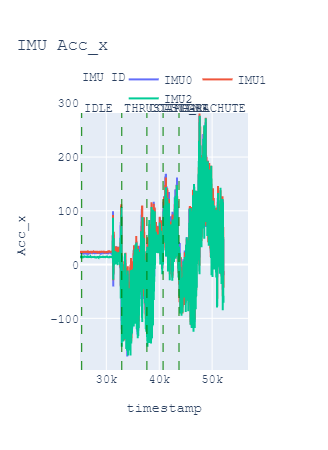

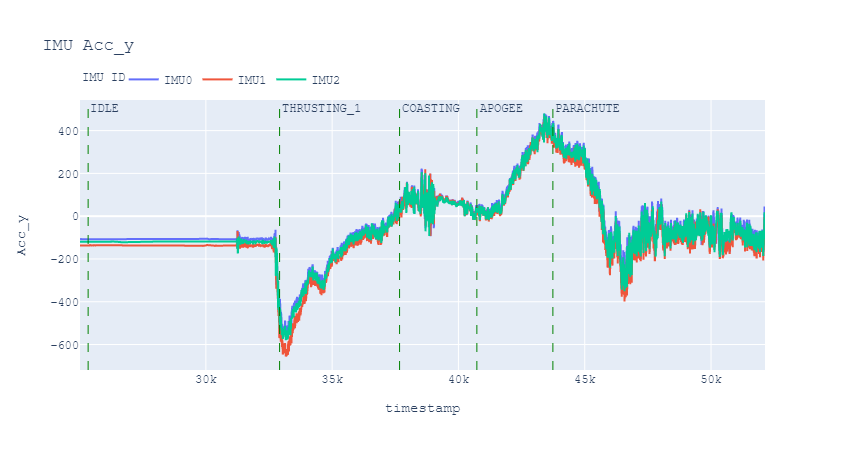

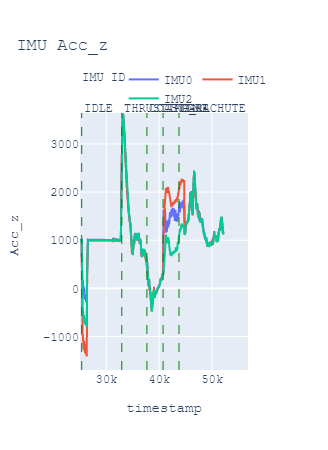

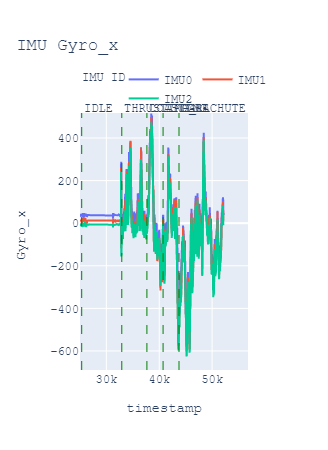

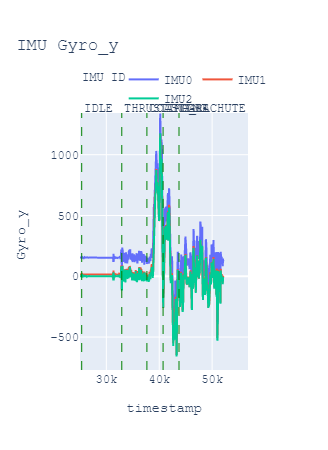

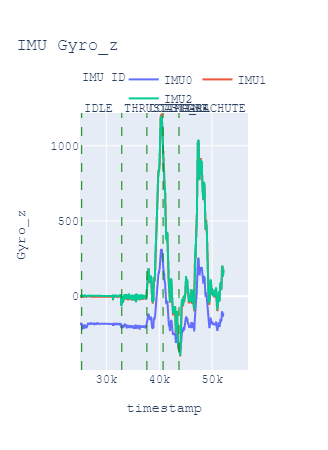

In [16]:
plot_imu_data(imu_df, flight_states)

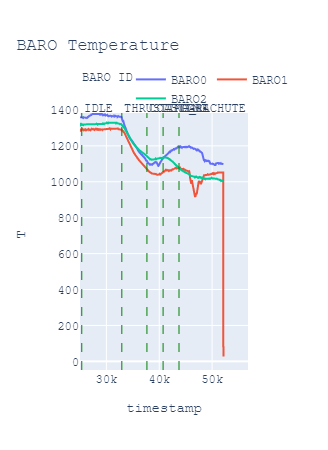

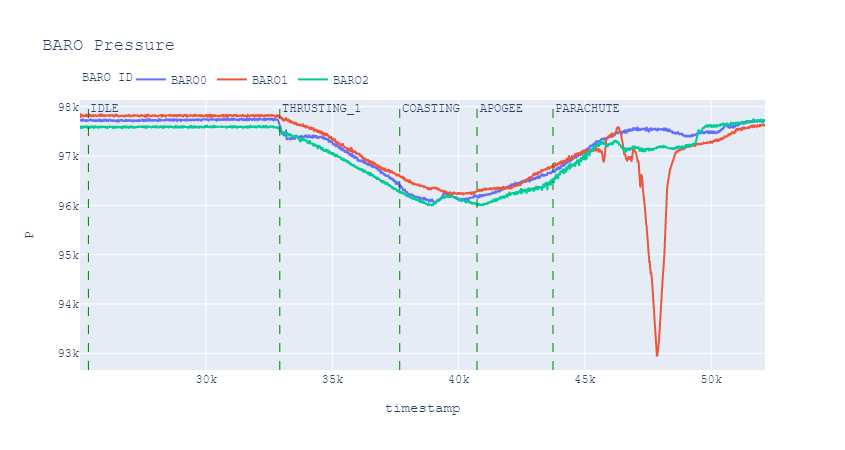

In [17]:
plot_baro_data(baro_df, flight_states)

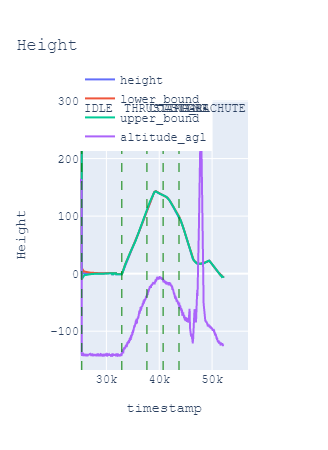

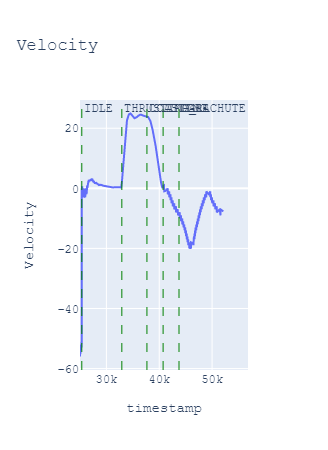

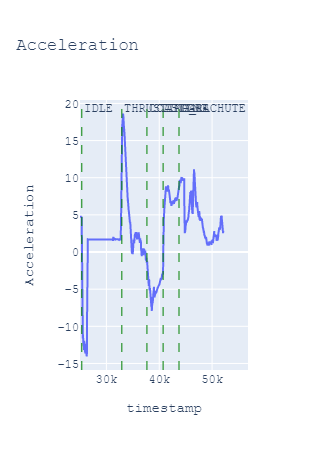

In [18]:
plot_flight_info(flight_info_df, flight_states)

In [19]:
sensor_info_df

ts  imu_0  imu_1  imu_2  baro_0  baro_1  baro_2
0     25001      0      1      0       0       1       0
1     25011      0      1      0       0       1       0
2     25021      0      1      0       0       1       0
3     25031      0      1      0       0       1       0
4     25041      0      1      0       0       1       0
...     ...    ...    ...    ...     ...     ...     ...
2709  52091      0      1      0       0       1       0
2710  52101      0      1      0       0       1       0
2711  52111      0      1      0       0       1       0
2712  52121      0      1      0       0       1       0
2713  52131      0      1      0       0       1       0

[2714 rows x 7 columns]